In [36]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import datasets

In [37]:
def Fig1_svd(A, k, p):
    """
    A = QQ'A = QB = QUhatDV' = UDV'
    parameters:
        A - m*n matrix
        k - target rank
        p - over-sampling parameter
    Outputs:
        matrices U,D,V in an approximate rank-(k+p) svd of A
    """
    m, n = A.shape
    # form an n*(k + p) Gaussian random matrix G
    G = np.random.rand(n, k+p)
    # form the sample matrix Y = AG.
    Y = A@G
    # orthonormalize the columns of the sample matrix Q = orth(Y)
    Q = linalg.orth(Y)
    # form the (k + p) * n matrix B = Q'*A
    B = Q.T@A
    # form the svd of the small matrix B
    Uhat, D, V = np.linalg.svd(B, full_matrices=False)
    # drop the last p components
    Uhat = Uhat[:,:k]; D = D[:k]; V = V[:,:k];
    # form U = Q * Uhat
    U = Q@Uhat
    return U, D, V, Q

In [38]:
def Fig3_svd(A, k, p):
    # Stage A
    m, n = A.shape
    G_c = np.random.randn(n, k+p)
    G_r = np.random.randn(m, k+p)
    Y_c = A @ G_c
    Y_r = np.transpose(A) @ G_r
    # potential source of error
    Q_c = linalg.orth(Y_c)
    Q_c = Q_c[:,:k]
    Q_r = linalg.orth(Y_r)
    Q_r = Q_r[:,:k]
    # Stage B
    # construct the linear system
    G = np.bmat([[G_r.T@Q_c,np.zeros((k+p,k))],[np.zeros((k+p,k)),G_c.T@Q_r],[np.eye(k),-np.eye(k)]])
    H = np.vstack((Y_r.T@Q_r,Y_c.T@Q_c,np.zeros((k,k))))
    CCT = np.linalg.lstsq(G,H,rcond = None)[0]
    C = CCT[:k,:]
    uh, D, vh = np.linalg.svd(C, full_matrices=False)
    U = Q_c @ uh
    V = Q_r @ vh
    return U, D, V, Q_c, Q_r

In [39]:
# classical algorithm  for svd?
def classical(A, k):
    """
    Given an m × n matrix A and integers k,
    generates low-rank approximation and error.
    """
    u, d, v = np.linalg.svd(A, full_matrices=False)
    return u[:,:k], d[:k], v[:,:k], d[k]

In [40]:
def esti_error(A,Q,r):
    # draw a sequence of standard Guassian vectors
    # generate the estimated error and probability
    m, n = A.shape
    error = 10*np.sqrt(2/np.pi)*max([np.linalg.norm(A@np.random.rand(n)-Q@(Q.T@(A@np.random.rand(n))),2) for i in range(r)])
    p = 1 - 10**(-r)
    return error, p

Text(0.5, 1.0, 'computational time')

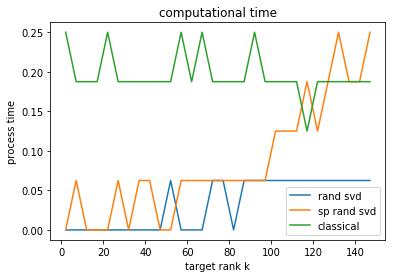

In [20]:
A = datasets.make_low_rank_matrix(500,500,30)
p = 10
time_cost_1 = []
time_cost_2 = []
time_cost_3 = []
for k in range(2,150,5):
    start_time_3 = time.process_time()
    classical(A,k)
    cost3 = time.process_time() - start_time_3
    time_cost_3.append(cost3)
    start_time_1 = time.process_time()
    Fig1_svd(A,k,p)
    cost1 = time.process_time() - start_time_1
    time_cost_1.append(cost1)
    start_time_2 = time.process_time()
    Fig3_svd(A,k,p)
    cost2 = time.process_time() - start_time_2
    time_cost_2.append(cost2)
plt.plot(range(2,150,5),time_cost_1,label='rand svd')
plt.plot(range(2,150,5),time_cost_2,label='sp rand svd')
plt.plot(range(2,150,5),time_cost_3,label='classical')
plt.legend()
plt.xlabel('target rank k')
plt.ylabel('process time')
plt.title('computational time')

In [28]:
A = datasets.make_low_rank_matrix(500,200,30)
def error_exp(A,p):
    err_class=[]
    err_1=[]
    err_3_c=[]
    err_3_r=[]
    for k in range(5,100,10):
        err_class.append(classical(A,k)[3])
        Q = Fig1_svd(A,k,p)[3]
        Qc= Fig3_svd(A,k,p)[-2]
        Qr = Fig3_svd(A,k,p)[-1]
        err_3_c.append(np.linalg.norm(A-Qc@Qc.T@A,2))
        err_3_r.append(np.linalg.norm(A-A@Qr@Qr.T,2))
        err_1.append(np.linalg.norm(A-Q@Q.T@A,2))
    return err_class,err_1,err_3_c,err_3_r

In [33]:
err_class,err_1,err_3_c,err_3_r=error_exp(A,5)
err_class_10,err_1_10,err_3_c_10,err_3_r_10=error_exp(A,10)

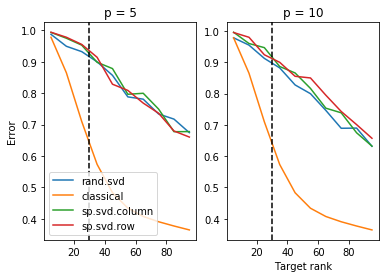

In [44]:
ax1=plt.subplot(121);ax2=plt.subplot(122)
ax1.plot(range(5,100,10),err_1,label='rand.svd')
ax1.plot(range(5,100,10),err_class,label='classical')
ax1.plot(range(5,100,10),err_3_c,label='sp.svd.column')
ax1.plot(range(5,100,10),err_3_r,label='sp.svd.row')
ax1.legend(loc=0)
ax1.set_title('p = 5')
ax1.set_ylabel('Error')
ax1.axvline(x=30,linestyle='--',color='k')
ax2.plot(range(5,100,10),err_1_10,label='rand.svd')
ax2.plot(range(5,100,10),err_class_10,label='classical')
ax2.plot(range(5,100,10),err_3_c_10,label='sp.svd.column')
ax2.plot(range(5,100,10),err_3_r_10,label='sp.svd.row')
ax2.set_title('p = 10')
ax2.set_xlabel('Target rank')
ax2.axvline(x=30,linestyle='--',color='k')

In [41]:
import imageio
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import os

def imgMatrix(directory):
    # Set gather all the images in an w*h x n array
    imgMatrix = []
    for imgName in os.listdir(directory):
        img = imageio.imread(os.path.abspath(directory) + "/" + imgName)
        img = np.transpose(np.array(img.flatten()))
        imgMatrix.append(img)
    imgMatrix = normalize(np.transpose(np.array(imgMatrix)))
    return imgMatrix

In [8]:
def pca(imgMatrix, n):
    # Perform PCA to get the eigenfaces 
    pca = PCA(n_components=n, svd_solver='full')
    pca.fit(imgMatrix)
    #s2 = np.linalg.svd(imgMatrix, full_matrices=True)[1]
    mean = np.mean(imgMatrix, axis = 1)
    shiftMatrix = imgMatrix - mean.reshape(len(mean),1)
    # Perform PCA using our SVD
    u1, d1, v1 = Fig1_svd(shiftMatrix,10,5)[:3]
    u2, d2, v2 = Fig3_svd(shiftMatrix,10,5)[:3]
     
    return pca.singular_values_, d1, d2

In [42]:
def pca(imgMatrix, n):
    # Perform PCA to get the eigenfaces 
    pca = PCA(n_components=n, svd_solver='full')
    pca.fit(imgMatrix)
    #s2 = np.linalg.svd(imgMatrix, full_matrices=True)[1]
    mean = np.mean(imgMatrix, axis = 1)
    shiftMatrix = imgMatrix - mean.reshape(len(mean),1)
    # Perform PCA using our SVD
    u1, d1, v1 = Fig1_svd(shiftMatrix,10,5)[:3]
    u2, d2, v2 = Fig3_svd(shiftMatrix,10,5)[:3]
     
    return pca.singular_values_, d1, d2

In [90]:
faceMatrix= imgMatrix("D:/study/19spr/math 490/faces")
faceMatrix.shape

(77760, 164)

In [93]:
# doing a classical svd and notice the singular value decays rapidly

In [92]:
u,d,v,e = classical(faceMatrix,163)

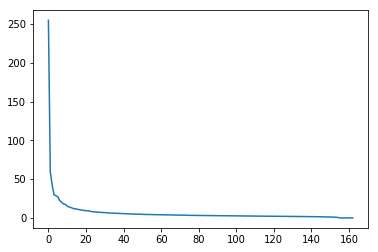

In [94]:
plt.plot(range(len(d)),d)

In [97]:
# 97% of variance is explained by first 20 column vectors
sum(d[:20]**2)/sum(d**2)

0.9728996269803042

In [79]:
# test on target rank
def pos_err_esti(inputMat,i,g):
    error=[]
    prob = []
    for k in range(2,20):
        Q = Fig1_svd(inputMat,k,g)[3]
        e,p = esti_error(inputMat,Q,i)
        error.append(e)
        prob.append(p)
    return error, prob

In [80]:
e_1,p1 = pos_err_esti(faceMatrix,1,5)

In [81]:
e_2,p2 = pos_err_esti(faceMatrix,2,5)

In [82]:
e_3,p3 = pos_err_esti(faceMatrix,3,5)

In [83]:
e_4,p4 = pos_err_esti(faceMatrix,4,5)

In [84]:
e_10,p10 = pos_err_esti(faceMatrix,10,5)

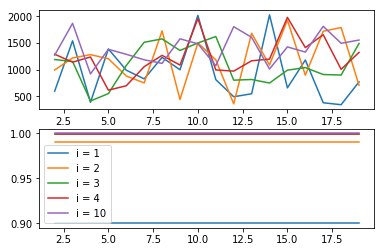

In [89]:
ax1=plt.subplot(211);ax2=plt.subplot(212)
ax1.plot(range(2,20),e_1,label='i = 1')
ax1.plot(range(2,20),e_2,label='i = 2')
ax1.plot(range(2,20),e_3,label='i = 3')
ax1.plot(range(2,20),e_4,label='i = 4')
ax1.plot(range(2,20),e_10,label='i = 10')
ax2.plot(range(2,20),p1,label='i = 1')
ax2.plot(range(2,20),p2,label='i = 2')
ax2.plot(range(2,20),p3,label='i = 3')
ax2.plot(range(2,20),p4,label='i = 4')
ax2.plot(range(2,20),p10,label='i = 10')
ax2.legend(loc=0)

In [105]:
# target rank = 4 perform well
error_matrix=np.vstack([np.asarray(e_1),np.asarray(e_2),np.asarray(e_3),np.asarray(e_4),np.asarray(e_10)])
np.mean(error_matrix,axis=0)

array([1067.91471773, 1385.42615201,  847.27493446, 1027.95104071,
        986.66385304, 1066.37761348, 1384.46910736, 1092.73734708,
       1693.78929542, 1137.74672726,  885.95135687, 1163.89458852,
       1215.22482618, 1397.71769144, 1171.92958907, 1295.55445773,
       1106.34575265, 1169.8860964 ])

In [106]:
# test on oversampling parameter
err=[]
for p in range(0,10):
    Q = Fig1_svd(faceMatrix,4,p)[3]
    e = esti_error(faceMatrix,Q,3)[0]
    err.append(e)

Text(0.5, 1.0, 'Approximation error')

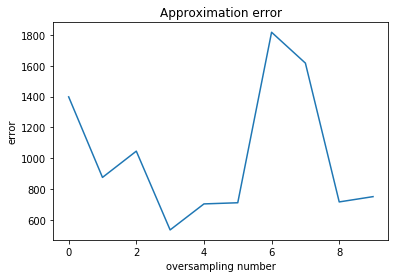

In [107]:
plt.plot(range(0,10),err)
plt.xlabel('oversampling number')
plt.ylabel('error')
plt.title('Approximation error')

In [108]:
# decide to use target rank = 4 & oversampling parameter = 3